In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct


SGD Final Accuracy: 0.9665


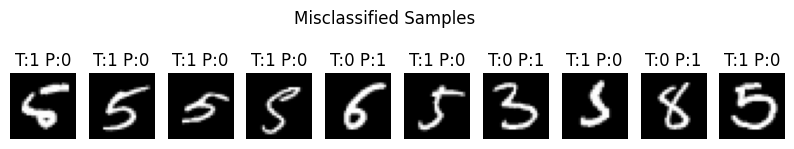

Momentum Final Accuracy: 0.9754


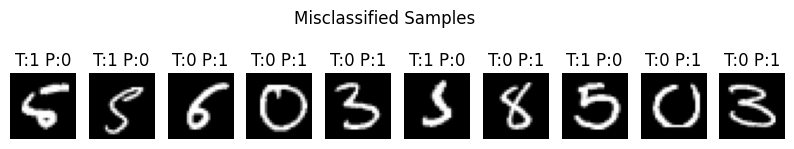

Nesterov Final Accuracy: 0.9739


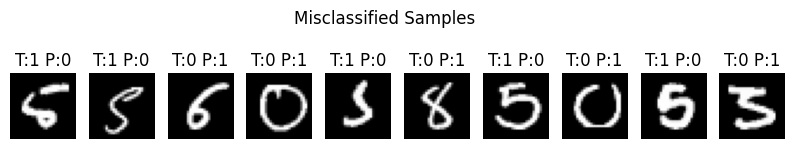

Adam Final Accuracy: 0.9762


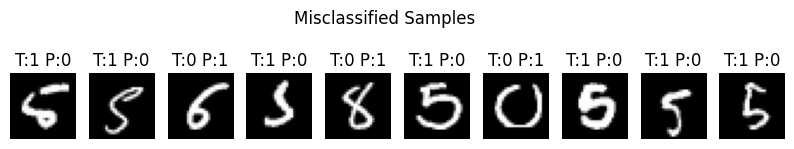

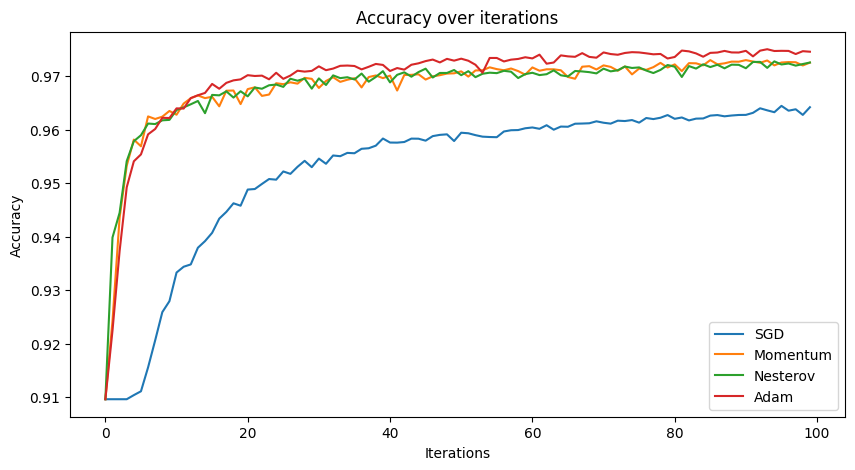

In [11]:

# ========== Load IDX Files ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images[:(len(images) // (rows * cols)) * rows * cols]
        return images.reshape(-1, rows * cols).astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels[:num]

# ========== 1. Sigmoid Function ==========
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# ====== 2. Mini Batch SGD: Algorithm 7.2 ======
def sgd_minibatch(X, y, eta=0.01, max_iters=10000, batch_size=64):
    m, n = X.shape
    theta = np.zeros(n)
    accuracy = []
    for i in range(max_iters):
        indices = np.random.randint(0, m, batch_size)
        X_batch, y_batch = X[indices], y[indices]
        gradient = X_batch.T @ (sigmoid(X_batch @ theta) - y_batch) / batch_size
        theta -= eta * gradient
        if i % 100 == 0:
            acc = np.mean((sigmoid(X @ theta) >= 0.5).astype(int) == y)
            accuracy.append(acc)
    return theta, accuracy

# ===== 3. Mini Batch SGD with Momentum: Algorithm 7.3 =====
def sgd_minibatch_momentum(X, y, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9):
    m, n = X.shape
    theta = np.zeros(n)
    v = np.zeros(n)
    accuracy = []
    for i in range(max_iters):
        indices = np.random.randint(0, m, batch_size)
        X_batch, y_batch = X[indices], y[indices]
        gradient = X_batch.T @ (sigmoid(X_batch @ theta) - y_batch) / batch_size
        v = momentum * v - eta * gradient
        theta += v
        if i % 100 == 0:
            acc = np.mean((sigmoid(X @ theta) >= 0.5).astype(int) == y)
            accuracy.append(acc)
    return theta, accuracy

# ===== 4. SGD with Nesterov Momentum: Eq. 7.34 =====
def sgd_nesterov(X, y, eta=0.01, max_iters=10000, batch_size=64, momentum=0.9):
    m, n = X.shape
    theta = np.zeros(n)
    v = np.zeros(n)
    accuracy = []
    for i in range(max_iters):
        indices = np.random.randint(0, m, batch_size)
        X_batch, y_batch = X[indices], y[indices]
        theta_lookahead = theta + momentum * v
        gradient = X_batch.T @ (sigmoid(X_batch @ theta_lookahead) - y_batch) / batch_size
        v = momentum * v - eta * gradient
        theta += v
        if i % 100 == 0:
            acc = np.mean((sigmoid(X @ theta) >= 0.5).astype(int) == y)
            accuracy.append(acc)
    return theta, accuracy

# ====== 5. Adam Optimizer: Algorithm 7.4 ======
def sgd_Adam(X, y, eta=0.001, max_iters=10000, batch_size=64, beta1=0.9, beta2=0.999, delta=1e-8):
    m, n = X.shape
    theta = np.zeros(n)
    m_t, v_t = np.zeros(n), np.zeros(n)
    accuracy = []
    for t in range(1, max_iters + 1):
        indices = np.random.randint(0, m, batch_size)
        X_batch, y_batch = X[indices], y[indices]
        gradient = X_batch.T @ (sigmoid(X_batch @ theta) - y_batch) / batch_size
        m_t = beta1 * m_t + (1 - beta1) * gradient
        v_t = beta2 * v_t + (1 - beta2) * (gradient ** 2)
        m_hat = m_t / (1 - beta1 ** t)
        v_hat = v_t / (1 - beta2 ** t)
        theta -= eta * m_hat / (np.sqrt(v_hat) + delta)
        if t % 100 == 0:
            acc = np.mean((sigmoid(X @ theta) >= 0.5).astype(int) == y)
            accuracy.append(acc)
    return theta, accuracy

# ========== Show Misclassified Samples ==========
def show_misclassified(X, true_labels, pred_labels, max_show=10):
    mis_idx = np.where(true_labels != pred_labels)[0][:max_show]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{true_labels[idx]} P:{pred_labels[idx]}")
    plt.suptitle("Misclassified Samples")
    plt.show()

# ========== Main ==========
if __name__ == "__main__":
    # === Load Data ===
    X_train = load_images("train-images.idx3-ubyte___")
    y_train = load_labels("train-labels.idx1-ubyte___")
    X_test = load_images("t10k-images.idx3-ubyte___")
    y_test = load_labels("t10k-labels.idx1-ubyte___")

    # === Choose binary classification target digit ===
    TARGET_DIGIT = 5
    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)

    # === Add bias term ===
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    # === Train and Evaluate ===
    algorithms = {"SGD": sgd_minibatch, "Momentum": sgd_minibatch_momentum, "Nesterov": sgd_nesterov, "Adam": sgd_Adam}

    accuracies = []
    labels = []

    for name, algo in algorithms.items():
        theta, acc = algo(X_train, y_train_bin)
        final_acc = np.mean((sigmoid(X_test @ theta) >= 0.5).astype(int) == y_test_bin)
        preds = (sigmoid(X_test @ theta) >= 0.5).astype(int)
        final_acc = np.mean(preds == y_test_bin)
        print(f"{name} Final Accuracy: {final_acc:.4f}")
        show_misclassified(X_test, y_test_bin, preds)
        accuracies.append(acc)
        labels.append(name)

    # === Plot Accuracy Comparison ===
    plt.figure(figsize=(10, 5))
    for acc, label in zip(accuracies, labels):
        plt.plot(acc, label=label)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over iterations")
    plt.show()

